# Evaluating an Image

After training our model, we will want to do a number of things<br>
1. see how the model did
2. test the model on an image where we have labeled data
3. evaluate an image where we don't have labeled data

This script goes through the functions that let us perform these tasks

In [1]:
from evaluate import *
parent_dir  = "../../"
results_dir = parent_dir + "results/"

# 1. Model Diagnostics

How do we know that we've finished training our model? We have to look at the diagnostics that were output from the training. We load in the diagnostics files with **get_diagnostics** which takes in the path to the diagnostics files as input. This is a list of directories with each trained model as an element in the list

In [3]:
#label_list = ["WSe_1vacancy", "WSe_2vacancy","WSe_1Doped","WSe_2Doped","WSe_metal_Doped","WSe_metal_vacancy"]
#label_list = [ "WSe_2vacancy","WSe_1Doped","WSe_2Doped","WSe_metal_Doped","WSe_metal_vacancy"]
label_list = ["1vacancy_GAN", "1vacancy_GAN_decaying_loss", "1vacancy_GAN_decaying_loss_instance_norm"]
results_dir_list = ["{}{}/".format(results_dir, label) for label in label_list]

diagnostics_data = get_diagnostic_data(results_dir_list, False)

Now we can plot our diagnostics. we can plot pixel-wise accuracy, loss, precision, and recall. Below is a description of the parameters:

**diagnostics_data**: obtained from above <br>
**label_list**: a list of the names of the models in **diagnostics_data**<br>
**diag**: either "loss", "accuracy", "precision", or "recall"<br>
**log**: true if we want a semilogy plot<br>
**invert**: plots (1 - data) if true<br>
**N**: smooths the data with $N$ sample averaging<br>

/home/skhan/stem_learning/code/3_evaluate/evaluate.py:244: RuntimeWarning: divide by zero encountered in log10
  g = np.log10(g) if log else g
/home/skhan/stem_learning/code/3_evaluate/evaluate.py:244: RuntimeWarning: divide by zero encountered in log10
  g = np.log10(g) if log else g


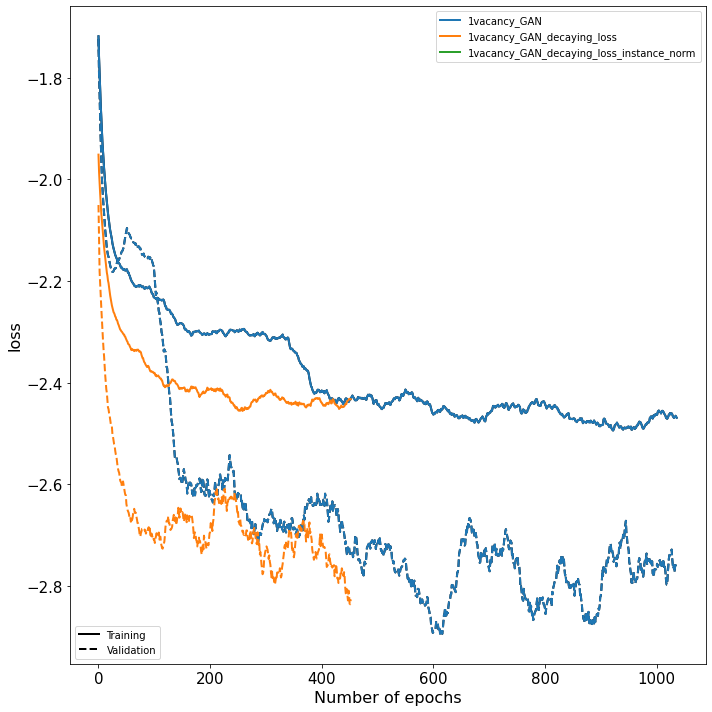

In [4]:
%matplotlib inline
plot_diagnostics(diagnostics_data, label_list, diag="loss", log=True, invert=False, N=50)
#log(1 - TP/(TP + FN))

# 2. Testing Model on Image

To evaluate an image, we need the following parameters:

**model_fn**         is the path to the model file that we load
<br>
**model_weights_fn** is the path to the model weights file
<br>
**input_file**       is the file we're interested in evaluating
<br>
**l_shape**          This is the size of the images that are fed into the model (see preprocessing section)
<br>
**avg**              is 1 if we want to average over rotatations and flips, 0 if we just want to evaluate the image as is
<br>
**plot**             true if we want to see the plots here
<br>
**save_data**        true if we want to save the plots to a file
<br>
**save_dir**         directory for where we want to save the data
<br>
**prefix**           if we want to save the images, we can apply a prefix to the image names.

In [5]:
lbl = "1vacancy_GAN_decaying_loss_instance_norm"
model_dir = results_dir + lbl + "/"
data_dir = parent_dir + "data/WSe/raw_experimental/RR/"


model_fn = model_dir + "model.json"                                              
model_weights_fn = model_dir + "weights.h5"
#input_file =  data_dir + "RR_1750 STEM 4.60 Mx HAADF_34.0pA_1024px_2.0us_Raw_Stack_16bit.tif"
#input_file =  data_dir + "RR_1840 STEM 4.60 Mx HAADF_33.9pA_1024px_2.0us_Raw_Stack_16bit.tif"
input_file =  data_dir + "RR_1847_STEM_4.60_Mx_HAADF_33.8pA_1024px_2.0us_Raw_Stack_16bit.tif"
l_shape = (256, 256)
stride  = (64,64)
avg = True
plot=True
save_data=False
save_dir = "./"                                                         
fname = "generated_1_vacancy_label.tiff"

In [6]:
input_img = process_image(input_file)

In [7]:
(lx, ly) = l_shape
sx, sy = stride
(size_x, size_y) = input_img.shape
input_cuts = cut_data(input_img, lx, ly, (sx, sy), standardize=True)
input_cuts = np.reshape(input_cuts, [-1, lx, ly, 1])
num_cuts = len(input_cuts)
a = stitch(size_x, size_y, sx, sy, input_cuts)

In [8]:
a = a.reshape(size_x, size_y)
imsave("1847_standardized.tiff", a.astype(np.float32))

In [9]:
!pwd

/home/skhan/stem_learning/code/3_evaluate


processing data
loading model
strides: (64, 64)
predicting data
stitching data


<IPython.core.display.Javascript object>


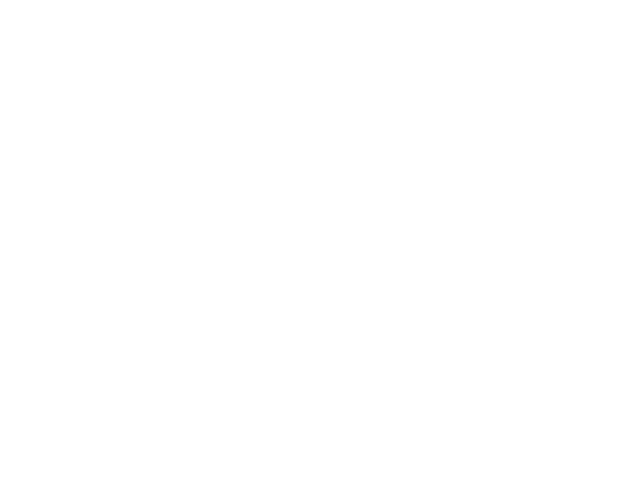

In [10]:
%matplotlib notebook
prediction = evaluate(model_fn, model_weights_fn, input_file, l_shape, stride,
                      avg=avg, plot=plot, save_data=save_data, save_dir=save_dir, fname=fname)

In [11]:
imsave("1840_dec_in.tiff", prediction.astype(np.float32))

In [12]:
imsave("1840_dec_con_in.tiff", convolve(2,prediction, thresh=0.6).astype(np.float32))

<IPython.core.display.Javascript object>


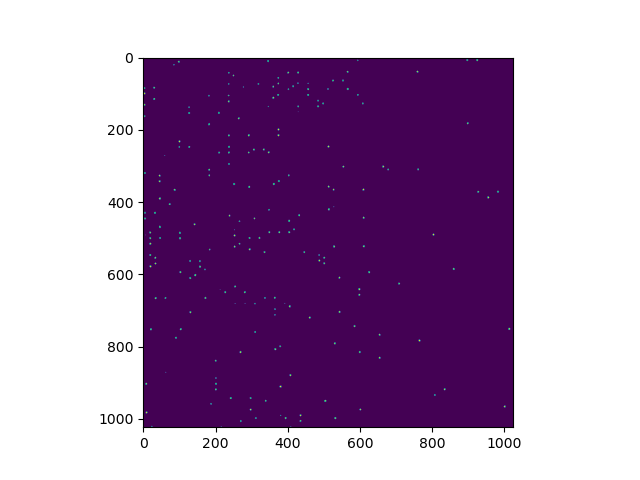

In [13]:
%matplotlib notebook
plt.imshow(convolve(2,prediction, thresh=0.6))
plt.show()

To test against the true labeled data, we run **test** which takes in the following:

**prediction** the output from **evaluate**
<br>
**label_file_list** is a list of label images associated with the input file (empty list if none)
<br>
**tol** the threshold for the labeled images that pixels with values <= tol to 0 and values > tol to 1
<br>
**plot** true if we want to see the plots here
<br>
**save_data** true if we want to save the plots to a file
<br>
**save_dir** directory for where we want to save the data
<br>
**prefix** if we want to save the images, we can apply a prefix to the image names.

In [16]:
#label_file_list = [data_dir + "label_{}.tiff".format(lbl)]
label_file_list = ["./labels/1847_img_manual_label_vacancies.tif"]
tol=.5
nconvs = 2
r = 7.5
TN = 0
plot=True
save_data=True
save_dir = "./"                                                         
prefix = "generated_{}_".format(lbl)
verbose = True

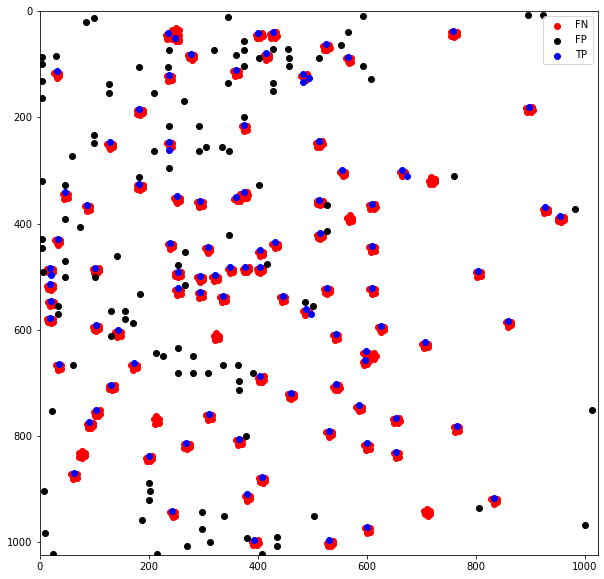

TP: 98
FP: 116
FN: 534
TN: 0

recall:    0.1550632911392405
precision: 0.45794392523364486
F1:        0.23167848699763594
bal_acc:   0.07753164556962025


In [17]:
%matplotlib inline
TP, FP, FN, TN, recall, precision, F1, bal_acc = calc_accuracy(prediction, label_file_list, tol=tol, 
                                                               nconvs=nconvs, r=r, TN=TN, plot=plot, 
                                                               save_data=save_data, save_dir=save_dir, 
                                                               prefix=prefix, verbose=verbose)

In [ ]:
plt.show()